### Disclaimer
AutoGluon'un documentation'ında da `TimeSeriesPredictor.predict` ve `TimeSeriesPredictor.fit` için bahsettiği gibi:

> random_seed (int or None, default = 123) – If provided, fixes the seed of the random number generator    for all models. This guarantees reproducible results for most models (except those trained on GPU because  of the non-determinism of GPU operations).

GPU'da aynı sonuçları almak imkansız derecede. CPU ise yakın sonuçlar verse de "most models" dediği kısım nedeniyle tam aynı değil. Ne kadar eşitlemeye çalışsam da birebir aynı sonucu alamadım. Gördüğüm kadarıyla skorlar 27.3-27.5 arası değişmekte. Yine de notebook'u CPU'da çalıştırmak daha doğru sonuçlar verir.  
Nihai sonuç öncesinde AutoGluon'da ne çalışmadı?  
Aklıma en önce gelenler şu şekilde:
- 2023-09'a kadar olan Dolar-TL verisinin kullanımı
- Çeşitli churn prediction hesaplama yöntemleri
- Tatil verilerinin ayın başlarına maplenmesi
- Nokta atışı tatil günleri yerine '7 ve 15 gün kala' featureları
- Verinin tümümün kullanımı (merchantları <8 diye ayırmamak)
- Başka çeşitli validation windows değerleri ve metrikler 

In [1]:
!python -m pip install autogluon --q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.11.0 requires botocore<1.34.23,>=1.33.2, but you have botocore 1.29.165 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.0 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.0.11 which is incompatible.
conda 23.11.0 requires packaging>=23.0, but you have packaging 21.3 which is incompatible.
google-cloud-aiplatform 0.6.0a1 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-automl 1.0.1 requires google-api-core[grpc]<2.0.0dev,>=1.14.0, but you have google-api-core 2.11.1 which is incompatible.
jupyter-events 0.9.0 requires js

In [2]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

In [3]:
import warnings
import pandas as pd
import numpy as np
import gc
from tqdm.notebook import tqdm
from datetime import datetime
tqdm.pandas()
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('/kaggle/input/iyzico-datathon/train.csv')
ss = pd.read_csv('/kaggle/input/iyzico-datathon/sample_submission.csv')

In [5]:
# Preprocessing. Veriyi parse edip ekstra columnlar ekle.
df = df.sort_values(["merchant_id", "month_id"]).reset_index(drop=True)
df['date'] = pd.to_datetime(df['month_id'].apply(lambda x: f'{str(x)[:4]}/{str(x)[4:]}/01'))
df['merchant_id'] = df['merchant_id'].apply(lambda x: x.split('_')[1]).astype(np.uint64)
df['merchant_source_name'] = df['merchant_source_name'].apply(lambda x: x.split('-')[1].strip()).astype(np.uint8)
df['settlement_period'] = df['settlement_period'].apply(lambda x: x.split('-')[1].strip()).astype(np.uint8)
df['working_type'] = df['working_type'].apply(lambda x: x.split('-')[1].strip()).astype(np.uint8)
df['mcc_id'] = df['mcc_id'].apply(lambda x: x.split('_')[1]).astype(np.uint8)
df['merchant_segment'] = df['merchant_segment'].apply(lambda x: x.split('-')[1].strip()).astype(np.uint8)
df['month'] = df['date'].dt.month.astype(np.uint8)
df['year'] = df['date'].dt.year.astype(np.uint16)
df = df.sort_values(by=['date', 'merchant_id'], ascending=True).reset_index(drop=True)
df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date,month,year
0,35,202001,2,1,6,166,4,4,2020-01-01,1,2020
1,63,202001,1,1,6,130,4,3,2020-01-01,1,2020
2,85,202001,1,1,5,73,4,19,2020-01-01,1,2020
3,86,202001,2,1,6,42,4,42,2020-01-01,1,2020
4,87,202001,1,1,5,130,4,5,2020-01-01,1,2020
...,...,...,...,...,...,...,...,...,...,...,...
291137,67783,202309,1,1,6,18,4,9,2023-09-01,9,2023
291138,67792,202309,2,1,6,42,4,3,2023-09-01,9,2023
291139,67794,202309,1,1,6,80,4,3,2023-09-01,9,2023
291140,67812,202309,1,1,5,110,4,17,2023-09-01,9,2023


In [6]:
ss['date'] = pd.to_datetime(ss['id'].apply(lambda x: f'{x[:4]}/{x[4:6]}/01'))
ss['merchant_id'] = ss['id'].apply(lambda x: x.split('merchant_')[-1]).astype(np.uint64)

features = ['merchant_source_name', 'settlement_period', 'working_type', 'mcc_id', 'merchant_segment']
ss = ss.merge(df.groupby('merchant_id')[features].first().reset_index(), how='left', on='merchant_id')
ss = ss.drop(columns=['id', 'net_payment_count'])
ss['month'] = ss['date'].dt.month.astype(np.uint8)
ss['year'] = ss['date'].dt.year.astype(np.uint16)
ss = ss.sort_values(by=['date', 'merchant_id'], ascending=True).reset_index(drop=True)
ss

,date,merchant_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,month,year
0,2023-10-01,1,2,1,5,128,4,10,2023
1,2023-10-01,2,1,1,6,144,4,10,2023
2,2023-10-01,3,1,1,5,126,4,10,2023
3,2023-10-01,4,1,1,5,24,4,10,2023
4,2023-10-01,5,1,1,5,112,4,10,2023
...,...,...,...,...,...,...,...,...,...
78175,2023-12-01,67800,2,1,6,24,4,12,2023
78176,2023-12-01,67807,1,1,5,68,4,12,2023
78177,2023-12-01,67808,1,1,5,42,4,12,2023
78178,2023-12-01,67812,1,1,5,110,4,12,2023


Her merchant'ın son girişleri eşit değil:

In [7]:
last_date_per_merchant = df.groupby('merchant_id')['date'].last().reset_index()
last_date_per_merchant

,merchant_id,date
0,1,2022-10-01
1,2,2023-09-01
2,3,2021-08-01
3,4,2023-09-01
4,5,2022-05-01
...,...,...
26055,67800,2021-06-01
26056,67807,2023-08-01
26057,67808,2022-08-01
26058,67812,2023-09-01


In [8]:
IDS = df["merchant_id"].unique()
for c in tqdm(IDS):
    last = df.loc[df["merchant_id"] == c, "net_payment_count"].values[-1]
    df.loc[df["merchant_id"] == c, "last"] = last
    ss.loc[ss["merchant_id"] == c, "last"] = last
df

  0%|          | 0/26060 [00:00<?, ?it/s]

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date,month,year,last
0,35,202001,2,1,6,166,4,4,2020-01-01,1,2020,3.0
1,63,202001,1,1,6,130,4,3,2020-01-01,1,2020,3.0
2,85,202001,1,1,5,73,4,19,2020-01-01,1,2020,25.0
3,86,202001,2,1,6,42,4,42,2020-01-01,1,2020,56.0
4,87,202001,1,1,5,130,4,5,2020-01-01,1,2020,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
291137,67783,202309,1,1,6,18,4,9,2023-09-01,9,2023,9.0
291138,67792,202309,2,1,6,42,4,3,2023-09-01,9,2023,3.0
291139,67794,202309,1,1,6,80,4,3,2023-09-01,9,2023,3.0
291140,67812,202309,1,1,5,110,4,17,2023-09-01,9,2023,17.0


In [9]:
df = df.drop(["month_id"], axis=1)
ss["net_payment_count"] = 0

Aşağıdakı grafikteki bazı "sivri" olan local minimum ve maksimum tarihler modelde kullanılıyor. Genel marketin trend değişimi olarak algılanabilir.

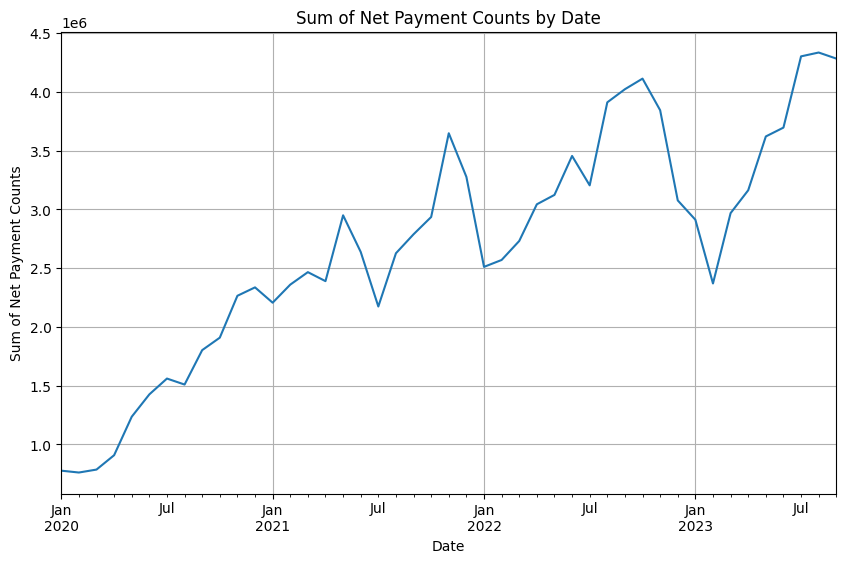

In [10]:
import matplotlib.pyplot as plt

net_payments_by_date = df.groupby('date')['net_payment_count'].sum()
plt.figure(figsize=(10, 6))
net_payments_by_date.plot()
plt.title('Sum of Net Payment Counts by Date')
plt.xlabel('Date')
plt.ylabel('Sum of Net Payment Counts')
plt.grid(True)
plt.show()

In [11]:
def filter_include(df):
    '''
    df: Train için kullanılacak ana dataframe
    Ana veriyi 3 parçaya böl. 
    - churn_df: 2023-09'a dair bir girdisi olmayan merchantlar'ı churn kabul et.
    - filter_df: 2023-09'a dair bir girdisi olup da toplam girdisi 8'den az olan merchantlar.
    - to_train_df: 2023-09'a dair bir girdisi olup da toplam girdisi 8'den fazla olan merchantlar.
    filter_df ve churn_df modelde kullanıldmadı.
    '''
    last_date_per_merchant = df.groupby('merchant_id')['date'].last().reset_index()
    # Churn treshold
    threshold_date = pd.Timestamp('2023-09-01 00:00:00')  
    selected_merchants = last_date_per_merchant[last_date_per_merchant['date'] >= threshold_date]['merchant_id']   
    filtered_df = df[df['merchant_id'].isin(selected_merchants)]
    churned_df = df[~df['merchant_id'].isin(selected_merchants)]
    # Group by merchant_id and count occurrences 
    merchant_counts = filtered_df['merchant_id'].value_counts()
    autog_selected_merchants = merchant_counts[merchant_counts >= 8].index
    to_train_df = filtered_df[filtered_df['merchant_id'].isin(autog_selected_merchants)]
    filtered_df = filtered_df[~filtered_df['merchant_id'].isin(to_train_df['merchant_id'])]
    to_train_df = to_train_df.sort_values(by=['merchant_id','date'])
    filtered_df = filtered_df.sort_values(by=['merchant_id','date'])
    churned_df = churned_df.sort_values(by=['merchant_id','date'])
    return to_train_df, filtered_df, churned_df

En son kayıtlı değer 2023-09-01'den azsa 'churned' kabul et. Bir merchant'ın 8'den az girdisi varsa modelde kullanmak yerine son değere eşitlemek üzere filter_df'e al.

In [12]:
df = df.copy()
to_train_df, filtered_df, churned_df = filter_include(df)

In [13]:
to_train_df.shape, filtered_df.shape, churned_df.shape # ((149830, 11), (6491, 11), (134821, 11))

((149830, 11), (6491, 11), (134821, 11))

In [14]:
overlap_train_filtered = to_train_df[to_train_df['merchant_id'].isin(filtered_df['merchant_id'])]

overlap_train_churned = to_train_df[to_train_df['merchant_id'].isin(churned_df['merchant_id'])]

overlap_filtered_churned = filtered_df[filtered_df['merchant_id'].isin(churned_df['merchant_id'])]

if not overlap_train_filtered.empty:
    print("Overlap between to_train_df and filtered_df")

if not overlap_train_churned.empty:
    print("Overlap between to_train_df and churned_df")

if not overlap_filtered_churned.empty:
    print("Overlap between filtered_df and churned_df")

if overlap_train_filtered.empty and overlap_train_churned.empty and overlap_filtered_churned.empty:
    print("No overlap between any of the DataFrames.")

No overlap between any of the DataFrames.


### AutoGluon için dataframelerin hazırlanması

In [15]:
categorical_features = [
    'merchant_source_name','settlement_period','working_type','mcc_id','merchant_segment'
]
for col in categorical_features:
    to_train_df[col] = to_train_df[col].astype('category')

In [16]:
static_features = ['merchant_id'] + categorical_features

In [17]:
to_train_df

,merchant_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date,month,year,last
25314,2,1,1,6,144,4,5,2020-07-01,7,2020,4.0
30304,2,1,1,6,144,4,4,2020-08-01,8,2020,4.0
35528,2,1,1,6,144,4,4,2020-09-01,9,2020,4.0
41017,2,1,1,6,144,4,5,2020-10-01,10,2020,4.0
46671,2,1,1,6,144,4,5,2020-11-01,11,2020,4.0
...,...,...,...,...,...,...,...,...,...,...,...
262257,67816,2,1,6,42,4,7,2023-05-01,5,2023,3.0
269322,67816,2,1,6,42,4,8,2023-06-01,6,2023,3.0
276539,67816,2,1,6,42,4,8,2023-07-01,7,2023,3.0
283854,67816,2,1,6,42,4,6,2023-08-01,8,2023,3.0


In [18]:
df_time = to_train_df[['merchant_id', 'date', 'net_payment_count']]
df_static = to_train_df[static_features]

In [19]:
df_time = df_time.sort_values(by=['merchant_id','date']).reset_index(drop=True)
df_time.head()

,merchant_id,date,net_payment_count
0,2,2020-07-01,5
1,2,2020-08-01,4
2,2,2020-09-01,4
3,2,2020-10-01,5
4,2,2020-11-01,5


In [20]:
df_static = df_static.sort_values(by=['merchant_id']).reset_index(drop=True)
df_static.head()

,merchant_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment
0,2,1,1,6,144,4
1,2,1,1,6,144,4
2,2,1,1,6,144,4
3,2,1,1,6,144,4
4,2,1,1,6,144,4


In [21]:
df_static = df_static.drop_duplicates().reset_index(drop=True)

In [22]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df_time,
    id_column="merchant_id",
    timestamp_column="date",
    static_features_df=df_static,
)

train_data.head()

net_payment_count
item_id timestamp                    
2       2020-07-01                  5
        2020-08-01                  4
        2020-09-01                  4
        2020-10-01                  5
        2020-11-01                  5

Ek olarak tatil günlerini ekle.

In [23]:
import holidays

timestamps = train_data.index.get_level_values("timestamp")
country_holidays = holidays.country_holidays(
    country="TR",
    years=range(timestamps.min().year, timestamps.max().year + 1),
)
pd.Series(country_holidays).sort_index()

2020-01-01                                       New Year's Day
2020-04-23              National Sovereignty and Children's Day
2020-05-01                                           Labour Day
2020-05-19       Commemoration of Ataturk, Youth and Sports Day
2020-05-24                          Ramadan Feast* (*estimated)
2020-05-25                  Ramadan Feast Holiday* (*estimated)
2020-05-26                  Ramadan Feast Holiday* (*estimated)
2020-07-15                     Democracy and National Unity Day
2020-07-31                        Sacrifice Feast* (*estimated)
2020-08-01                Sacrifice Feast Holiday* (*estimated)
2020-08-02                Sacrifice Feast Holiday* (*estimated)
2020-08-03                Sacrifice Feast Holiday* (*estimated)
2020-08-30                                          Victory Day
2020-10-29                                         Republic Day
2021-01-01                                       New Year's Day
2021-04-23              National Soverei

In [24]:
country_holidays

{datetime.date(2020, 1, 1): "New Year's Day", datetime.date(2020, 4, 23): "National Sovereignty and Children's Day", datetime.date(2020, 5, 1): 'Labour Day', datetime.date(2020, 5, 19): 'Commemoration of Ataturk, Youth and Sports Day', datetime.date(2020, 7, 15): 'Democracy and National Unity Day', datetime.date(2020, 8, 30): 'Victory Day', datetime.date(2020, 10, 29): 'Republic Day', datetime.date(2020, 5, 24): 'Ramadan Feast* (*estimated)', datetime.date(2020, 5, 25): 'Ramadan Feast Holiday* (*estimated)', datetime.date(2020, 5, 26): 'Ramadan Feast Holiday* (*estimated)', datetime.date(2020, 7, 31): 'Sacrifice Feast* (*estimated)', datetime.date(2020, 8, 1): 'Sacrifice Feast Holiday* (*estimated)', datetime.date(2020, 8, 2): 'Sacrifice Feast Holiday* (*estimated)', datetime.date(2020, 8, 3): 'Sacrifice Feast Holiday* (*estimated)', datetime.date(2021, 1, 1): "New Year's Day", datetime.date(2021, 4, 23): "National Sovereignty and Children's Day", datetime.date(2021, 5, 1): 'Labour Day

In [25]:
import datetime
# Yukarıda bahsettiğim grafikteki minimum-maksimum değerleri:
custom_dates = {
    datetime.date(2021, 1, 1): "Lowest",
    datetime.date(2021, 5, 1): "Highest",
    datetime.date(2021, 7, 1): "Lowest",
    datetime.date(2021, 11, 1): "Highest",
    datetime.date(2022, 1, 1): "Lowest",
    datetime.date(2023, 3, 1): "Lowest",
}
'''
    datetime.date(2020, 4, 1): "Corona",
    datetime.date(2020, 5, 1): "Corona",
    datetime.date(2020, 6, 1): "Corona",
    # datetime.date(2021, 4, 1): "Corona",
    # datetime.date(2021, 5, 1): "Corona",
    datetime.date(2023, 3, 1): "Deprem", Minimum degerlerden biri buraya tekabul ediyor
    datetime.date(2023, 5, 1): "Secim",
    datetime.date(2023, 6, 1): "Secim",
'''

'\n    datetime.date(2020, 4, 1): "Corona",\n    datetime.date(2020, 5, 1): "Corona",\n    datetime.date(2020, 6, 1): "Corona",\n    # datetime.date(2021, 4, 1): "Corona",\n    # datetime.date(2021, 5, 1): "Corona",\n    datetime.date(2023, 3, 1): "Deprem", Minimum degerlerden biri buraya tekabul ediyor\n    datetime.date(2023, 5, 1): "Secim",\n    datetime.date(2023, 6, 1): "Secim",\n'

In [26]:
merged_dates = country_holidays.copy()
for date, event in custom_dates.items():
    if date in merged_dates:
        merged_dates[date] += ", " + event
    else:
        merged_dates[date] = event

merged_dates

{datetime.date(2020, 1, 1): "New Year's Day", datetime.date(2020, 4, 23): "National Sovereignty and Children's Day", datetime.date(2020, 5, 1): 'Labour Day', datetime.date(2020, 5, 19): 'Commemoration of Ataturk, Youth and Sports Day', datetime.date(2020, 7, 15): 'Democracy and National Unity Day', datetime.date(2020, 8, 30): 'Victory Day', datetime.date(2020, 10, 29): 'Republic Day', datetime.date(2020, 5, 24): 'Ramadan Feast* (*estimated)', datetime.date(2020, 5, 25): 'Ramadan Feast Holiday* (*estimated)', datetime.date(2020, 5, 26): 'Ramadan Feast Holiday* (*estimated)', datetime.date(2020, 7, 31): 'Sacrifice Feast* (*estimated)', datetime.date(2020, 8, 1): 'Sacrifice Feast Holiday* (*estimated)', datetime.date(2020, 8, 2): 'Sacrifice Feast Holiday* (*estimated)', datetime.date(2020, 8, 3): 'Sacrifice Feast Holiday* (*estimated)', datetime.date(2021, 1, 1): "New Year's Day; New Year's Day, Lowest", datetime.date(2021, 4, 23): "National Sovereignty and Children's Day", datetime.date(

In [27]:
def add_date_features(
    ts_df: TimeSeriesDataFrame, 
    country_holidays: dict,
    include_individual_holidays: bool = True,
    include_holiday_indicator: bool = True,
) -> TimeSeriesDataFrame:
    """Tatil günleri ve bahsedilen maksimum-minimum degerleri ekle"""
    ts_df = ts_df.copy()
    timestamps = ts_df.index.get_level_values("timestamp")
    country_holidays_df = pd.get_dummies(pd.Series(country_holidays)).astype(float)
    holidays_df = country_holidays_df.reindex(timestamps.date).fillna(0)
    if include_individual_holidays:
        ts_df[holidays_df.columns] = holidays_df.values
    if include_holiday_indicator:
        ts_df["Holiday"] = holidays_df.max(axis=1).values
    return ts_df

In [28]:
train_data = add_date_features(train_data, merged_dates)
train_data

net_payment_count  \
item_id timestamp                       
2       2020-07-01                  5   
        2020-08-01                  4   
        2020-09-01                  4   
        2020-10-01                  5   
        2020-11-01                  5   
...                               ...   
67816   2023-05-01                  7   
        2023-06-01                  8   
        2023-07-01                  8   
        2023-08-01                  6   
        2023-09-01                  3   

                    Commemoration of Ataturk, Youth and Sports Day  \
item_id timestamp                                                    
2       2020-07-01                                             0.0   
        2020-08-01                                             0.0   
        2020-09-01                                             0.0   
        2020-10-01                                             0.0   
        2020-11-01                                             0.0   
...                                                            ...   
67816   2023-05-01                                             0.0   
        2023-06-01                                             0.0   
        2023-07-01                                             0.0   
        2023-08-01                                             0.0   
        2023-09-01                                             0.0   

                    Democracy and National Unity Day  Highest  Labour Day  \
item_id timestamp                                                           
2       2020-07-01                               0.0      0.0         0.0   
        2020-08-01                               0.0      0.0         0.0   
        2020-09-01                               0.0      0.0         0.0   
        2020-10-01                               0.0      0.0         0.0   
        2020-11-01                               0.0      0.0         0.0   
...                                              ...      ...         ...   
67816   2023-05-01                               0.0      0.0         1.0   
        2023-06-01                               0.0      0.0         0.0   
        2023-07-01                               0.0      0.0         0.0   
        2023-08-01                               0.0      0.0         0.0   
        2023-09-01                               0.0      0.0         0.0   

                    Labour Day; Labour Day, Highest  Lowest  \
item_id timestamp                                             
2       2020-07-01                              0.0     0.0   
        2020-08-01                              0.0     0.0   
        2020-09-01                              0.0     0.0   
        2020-10-01                              0.0     0.0   
        2020-11-01                              0.0     0.0   
...                                             ...     ...   
67816   2023-05-01                              0.0     0.0   
        2023-06-01                              0.0     0.0   
        2023-07-01                              0.0     0.0   
        2023-08-01                              0.0     0.0   
        2023-09-01                              0.0     0.0   

                    National Sovereignty and Children's Day  \
item_id timestamp                                             
2       2020-07-01                                      0.0   
        2020-08-01                                      0.0   
        2020-09-01                                      0.0   
        2020-10-01                                      0.0   
        2020-11-01                                      0.0   
...                                                     ...   
67816   2023-05-01                                      0.0   
        2023-06-01                                      0.0   
        2023-07-01                                      0.0   
        2023-08-01                                      0.0 

In [29]:
train_data = train_data.rename(columns={'net_payment_count': 'target'})

In [30]:
holiday_columns = train_data.columns.to_list()
holiday_columns.remove('target')
holiday_columns

['Commemoration of Ataturk, Youth and Sports Day',
 'Democracy and National Unity Day',
 'Highest',
 'Labour Day',
 'Labour Day; Labour Day, Highest',
 'Lowest',
 "National Sovereignty and Children's Day",
 "National Sovereignty and Children's Day; Ramadan Feast Holiday* (*estimated)",
 "New Year's Day",
 "New Year's Day; New Year's Day, Lowest",
 'Ramadan Feast Holiday* (*estimated)',
 'Ramadan Feast* (*estimated)',
 'Republic Day',
 'Sacrifice Feast Holiday* (*estimated)',
 'Sacrifice Feast* (*estimated)',
 'Victory Day',
 'Holiday']

### Model eğitimi

In [31]:
predictor = TimeSeriesPredictor(prediction_length=3,target="target",
                                eval_metric='MAE', freq='MS',
                               known_covariates_names=holiday_columns).fit(train_data,
                                                                        num_val_windows=4, 
                                                                           refit_full=True, val_step_size = 3,
                                                                           presets='best_quality', random_seed=42) 

No path specified. Models will be saved in: "AutogluonModels/ag-20240212_211916"
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240212_211916'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Dec 19 13:14:11 UTC 2023
CPU Count:          4
GPU Count:          0
Memory Avail:       30.08 GB / 31.36 GB (95.9%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAE,
 'freq': 'MS',
 'hyperparameters': 'default',
 'known_covariates_names': ['Commemoration of Ataturk, Youth and Sports Day',
                            'Democracy and National Unity Day',
                            'Highest',
                            'Labour Day',
                            'Labour Day; Labour Day, Highest',
                            

In [32]:
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-177.205531,926.472592,17.812107,9
1,AutoARIMA,-186.537725,667.667521,1603.992459,6
2,RecursiveTabular,-205.094838,0.642758,419.368873,7
3,AutoETS,-215.115493,240.949392,579.793268,4
4,DynamicOptimizedTheta,-218.156366,16.574241,68.325046,5
5,CrostonSBA,-276.797796,7.950007,41.471650,2
6,DirectTabular,-286.845348,0.638680,36.471244,8
7,SeasonalNaive,-302.083925,7.102472,24.853888,1
8,NPTS,-390.906369,12.960363,38.825077,3
9,WeightedEnsemble_FULL,NaN,NaN,17.812107,18


### Prediction

In [33]:
train_data_freq = train_data.convert_frequency(freq="MS")
train_data_freq

target  Commemoration of Ataturk, Youth and Sports Day  \
item_id timestamp                                                            
2       2020-07-01     5.0                                             0.0   
        2020-08-01     4.0                                             0.0   
        2020-09-01     4.0                                             0.0   
        2020-10-01     5.0                                             0.0   
        2020-11-01     5.0                                             0.0   
...                    ...                                             ...   
67816   2023-05-01     7.0                                             0.0   
        2023-06-01     8.0                                             0.0   
        2023-07-01     8.0                                             0.0   
        2023-08-01     6.0                                             0.0   
        2023-09-01     3.0                                             0.0   

                    Democracy and National Unity Day  Highest  Labour Day  \
item_id timestamp                                                           
2       2020-07-01                               0.0      0.0         0.0   
        2020-08-01                               0.0      0.0         0.0   
        2020-09-01                               0.0      0.0         0.0   
        2020-10-01                               0.0      0.0         0.0   
        2020-11-01                               0.0      0.0         0.0   
...                                              ...      ...         ...   
67816   2023-05-01                               0.0      0.0         1.0   
        2023-06-01                               0.0      0.0         0.0   
        2023-07-01                               0.0      0.0         0.0   
        2023-08-01                               0.0      0.0         0.0   
        2023-09-01                               0.0      0.0         0.0   

                    Labour Day; Labour Day, Highest  Lowest  \
item_id timestamp                                             
2       2020-07-01                              0.0     0.0   
        2020-08-01                              0.0     0.0   
        2020-09-01                              0.0     0.0   
        2020-10-01                              0.0     0.0   
        2020-11-01                              0.0     0.0   
...                                             ...     ...   
67816   2023-05-01                              0.0     0.0   
        2023-06-01                              0.0     0.0   
        2023-07-01                              0.0     0.0   
        2023-08-01                              0.0     0.0   
        2023-09-01                              0.0     0.0   

                    National Sovereignty and Children's Day  \
item_id timestamp                                             
2       2020-07-01                                      0.0   
        2020-08-01                                      0.0   
        2020-09-01                                      0.0   
        2020-10-01                                      0.0   
        2020-11-01                                      0.0   
...                                                     ...   
67816   2023-05-01                                      0.0   
        2023-06-01                                      0.0   
        2023-07-01                                      0.0   
        2023-08-01                                      0.0   
        2023-09-01                                      0.0   

                    National Sovereignty and Children's Day; Ramadan Feast Holiday* (*estimated)  \
item_id timestamp                                                                                  
2       2020-07-01                                                0.0                              
        2020-08-01                                             

In [34]:
train_data_freq.isnull().sum()

target                                                                          22274
Commemoration of Ataturk, Youth and Sports Day                                  22274
Democracy and National Unity Day                                                22274
Highest                                                                         22274
Labour Day                                                                      22274
Labour Day; Labour Day, Highest                                                 22274
Lowest                                                                          22274
National Sovereignty and Children's Day                                         22274
National Sovereignty and Children's Day; Ramadan Feast Holiday* (*estimated)    22274
New Year's Day                                                                  22274
New Year's Day; New Year's Day, Lowest                                          22274
Ramadan Feast Holiday* (*estimated)                   

In [35]:
train_data = train_data_freq

In [36]:
train_data.isnull().sum()

target                                                                          22274
Commemoration of Ataturk, Youth and Sports Day                                  22274
Democracy and National Unity Day                                                22274
Highest                                                                         22274
Labour Day                                                                      22274
Labour Day; Labour Day, Highest                                                 22274
Lowest                                                                          22274
National Sovereignty and Children's Day                                         22274
National Sovereignty and Children's Day; Ramadan Feast Holiday* (*estimated)    22274
New Year's Day                                                                  22274
New Year's Day; New Year's Day, Lowest                                          22274
Ramadan Feast Holiday* (*estimated)                   

In [37]:
future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=3)
future_index

MultiIndex([(    2, '2023-10-01'),
            (    2, '2023-11-01'),
            (    2, '2023-12-01'),
            (    4, '2023-10-01'),
            (    4, '2023-11-01'),
            (    4, '2023-12-01'),
            (   29, '2023-10-01'),
            (   29, '2023-11-01'),
            (   29, '2023-12-01'),
            (   32, '2023-10-01'),
            ...
            (67775, '2023-12-01'),
            (67783, '2023-10-01'),
            (67783, '2023-11-01'),
            (67783, '2023-12-01'),
            (67812, '2023-10-01'),
            (67812, '2023-11-01'),
            (67812, '2023-12-01'),
            (67816, '2023-10-01'),
            (67816, '2023-11-01'),
            (67816, '2023-12-01')],
           names=['item_id', 'timestamp'], length=16458)

In [38]:
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = add_date_features(pd.DataFrame(index=future_index), merged_dates)

In [39]:
known_covariates

Commemoration of Ataturk, Youth and Sports Day  \
item_id timestamp                                                    
2       2023-10-01                                             0.0   
        2023-11-01                                             0.0   
        2023-12-01                                             0.0   
4       2023-10-01                                             0.0   
        2023-11-01                                             0.0   
...                                                            ...   
67812   2023-11-01                                             0.0   
        2023-12-01                                             0.0   
67816   2023-10-01                                             0.0   
        2023-11-01                                             0.0   
        2023-12-01                                             0.0   

                    Democracy and National Unity Day  Highest  Labour Day  \
item_id timestamp                                                           
2       2023-10-01                               0.0      0.0         0.0   
        2023-11-01                               0.0      0.0         0.0   
        2023-12-01                               0.0      0.0         0.0   
4       2023-10-01                               0.0      0.0         0.0   
        2023-11-01                               0.0      0.0         0.0   
...                                              ...      ...         ...   
67812   2023-11-01                               0.0      0.0         0.0   
        2023-12-01                               0.0      0.0         0.0   
67816   2023-10-01                               0.0      0.0         0.0   
        2023-11-01                               0.0      0.0         0.0   
        2023-12-01                               0.0      0.0         0.0   

                    Labour Day; Labour Day, Highest  Lowest  \
item_id timestamp                                             
2       2023-10-01                              0.0     0.0   
        2023-11-01                              0.0     0.0   
        2023-12-01                              0.0     0.0   
4       2023-10-01                              0.0     0.0   
        2023-11-01                              0.0     0.0   
...                                             ...     ...   
67812   2023-11-01                              0.0     0.0   
        2023-12-01                              0.0     0.0   
67816   2023-10-01                              0.0     0.0   
        2023-11-01                              0.0     0.0   
        2023-12-01                              0.0     0.0   

                    National Sovereignty and Children's Day  \
item_id timestamp                                             
2       2023-10-01                                      0.0   
        2023-11-01                                      0.0   
        2023-12-01                                      0.0   
4       2023-10-01                                      0.0   
        2023-11-01                                      0.0   
...                                                     ...   
67812   2023-11-01                                      0.0   
        2023-12-01                                      0.0   
67816   2023-10-01                                      0.0   
        2023-11-01                                      0.0   
        2023-12-01                                      0.0   

                    National Sovereignty and Children's Day; Ramadan Feast Holiday* (*estimated)  \
item_id timestamp                                                                                  
2       2023-10-01                                                0.0                              
        2023-11-01                                                0.0                              
        2023-12-01                                                0

In [40]:
predictions = predictor.predict(train_data, known_covariates=known_covariates)

data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


In [41]:
predictions

mean       0.1       0.2        0.3        0.4  \
item_id timestamp                                                         
2       2023-10-01   4.619579  3.548232  3.913140   4.176479   4.406442   
        2023-11-01   4.627419  3.450892  3.856550   4.148658   4.396809   
        2023-12-01   4.316411  3.002045  3.456279   3.780927   4.058900   
4       2023-10-01   4.217005 -0.877681  0.859273   2.112637   3.204236   
        2023-11-01   3.857157 -2.368529 -0.222867   1.306515   2.617442   
...                       ...       ...       ...        ...        ...   
67812   2023-11-01  19.557044 -2.494656  5.090363  10.546193  15.208588   
        2023-12-01  16.144020 -8.344172  0.095423   6.140655  11.328365   
67816   2023-10-01   0.872042 -3.913651 -2.282841  -1.106010  -0.079677   
        2023-11-01  -1.526393 -8.255760 -5.949115  -4.286657  -2.853501   
        2023-12-01  -1.650415 -9.904215 -7.074198  -5.041992  -3.284410   

                          0.5        0.6        0.7        0.8        0.9  
item_id timestamp                                                          
2       2023-10-01   4.619579   4.833511   5.060307   5.325125   5.696706  
        2023-11-01   4.627419   4.862377   5.111734   5.402959   5.805523  
        2023-12-01   4.316411   4.572381   4.849749   5.172925   5.621928  
4       2023-10-01   4.217005   5.233094   6.311483   7.571016   9.335809  
        2023-11-01   3.857157   5.079283   6.388884   7.930047  10.081968  
...                       ...        ...        ...        ...        ...  
67812   2023-11-01  19.557044  23.930195  28.594305  34.047484  41.615707  
        2023-12-01  16.144020  20.963344  26.130361  32.180694  40.556398  
67816   2023-10-01   0.872042   1.827102   2.840142   4.023181   5.682002  
        2023-11-01  -1.526393  -0.202417   1.230367   2.903420   5.230529  
        2023-12-01  -1.650415  -0.009200   1.724599   3.774840   6.629739  

[16458 rows x 10 columns]

In [42]:
fs = ss[['merchant_id','date', 'year', 'month']]
fs

,merchant_id,date,year,month
0,1,2023-10-01,2023,10
1,2,2023-10-01,2023,10
2,3,2023-10-01,2023,10
3,4,2023-10-01,2023,10
4,5,2023-10-01,2023,10
...,...,...,...,...
78175,67800,2023-12-01,2023,12
78176,67807,2023-12-01,2023,12
78177,67808,2023-12-01,2023,12
78178,67812,2023-12-01,2023,12


In [43]:
pred_sub = pd.merge(fs, predictions, left_on=['merchant_id', 'date'], right_on=['item_id', 'timestamp'])
pred_sub['net_payment_count'] = pred_sub['mean']

In [44]:
pred_sub

,merchant_id,date,year,month,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,net_payment_count
0,2,2023-10-01,2023,10,4.619579,3.548232,3.913140,4.176479,4.406442,4.619579,4.833511,5.060307,5.325125,5.696706,4.619579
1,4,2023-10-01,2023,10,4.217005,-0.877681,0.859273,2.112637,3.204236,4.217005,5.233094,6.311483,7.571016,9.335809,4.217005
2,29,2023-10-01,2023,10,6514.124326,5036.958540,5542.041451,5906.391726,6221.168248,6514.124326,6807.635487,7120.202829,7485.584822,7995.323126,6514.124326
3,32,2023-10-01,2023,10,3.716096,2.455296,2.886964,3.198313,3.466316,3.716096,3.966192,4.232936,4.544873,4.979194,3.716096
4,51,2023-10-01,2023,10,3.949946,2.567601,3.039749,3.380380,3.675554,3.949946,4.225000,4.517539,4.859400,5.337100,3.949946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16453,67760,2023-12-01,2023,12,2.870453,1.427338,1.925176,2.281788,2.586969,2.870453,3.152784,3.457446,3.812900,4.306569,2.870453
16454,67775,2023-12-01,2023,12,7.855806,1.348770,3.592893,5.203990,6.581659,7.855806,9.133958,10.507587,12.106880,14.340776,7.855806
16455,67783,2023-12-01,2023,12,5.659430,3.178624,4.035381,4.648416,5.172873,5.659430,6.143189,6.666789,7.277369,8.125159,5.659430
16456,67812,2023-12-01,2023,12,16.144020,-8.344172,0.095423,6.140655,11.328365,16.144020,20.963344,26.130361,32.180694,40.556398,16.144020


In [45]:
pred_sub.sort_values(by=['merchant_id', 'date'])

,merchant_id,date,year,month,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,net_payment_count
0,2,2023-10-01,2023,10,4.619579,3.548232,3.913140,4.176479,4.406442,4.619579,4.833511,5.060307,5.325125,5.696706,4.619579
5486,2,2023-11-01,2023,11,4.627419,3.450892,3.856550,4.148658,4.396809,4.627419,4.862377,5.111734,5.402959,5.805523,4.627419
10972,2,2023-12-01,2023,12,4.316411,3.002045,3.456279,3.780927,4.058900,4.316411,4.572381,4.849749,5.172925,5.621928,4.316411
1,4,2023-10-01,2023,10,4.217005,-0.877681,0.859273,2.112637,3.204236,4.217005,5.233094,6.311483,7.571016,9.335809,4.217005
5487,4,2023-11-01,2023,11,3.857157,-2.368529,-0.222867,1.306515,2.617442,3.857157,5.079283,6.388884,7.930047,10.081968,3.857157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,67812,2023-11-01,2023,11,19.557044,-2.494656,5.090363,10.546193,15.208588,19.557044,23.930195,28.594305,34.047484,41.615707,19.557044
16456,67812,2023-12-01,2023,12,16.144020,-8.344172,0.095423,6.140655,11.328365,16.144020,20.963344,26.130361,32.180694,40.556398,16.144020
5485,67816,2023-10-01,2023,10,0.872042,-3.913651,-2.282841,-1.106010,-0.079677,0.872042,1.827102,2.840142,4.023181,5.682002,0.872042
10971,67816,2023-11-01,2023,11,-1.526393,-8.255760,-5.949115,-4.286657,-2.853501,-1.526393,-0.202417,1.230367,2.903420,5.230529,-1.526393


In [46]:
pred_sub[['merchant_id','date', 'year', 'month','net_payment_count']]

,merchant_id,date,year,month,net_payment_count
0,2,2023-10-01,2023,10,4.619579
1,4,2023-10-01,2023,10,4.217005
2,29,2023-10-01,2023,10,6514.124326
3,32,2023-10-01,2023,10,3.716096
4,51,2023-10-01,2023,10,3.949946
...,...,...,...,...,...
16453,67760,2023-12-01,2023,12,2.870453
16454,67775,2023-12-01,2023,12,7.855806
16455,67783,2023-12-01,2023,12,5.659430
16456,67812,2023-12-01,2023,12,16.144020


In [47]:
filtered_df = filtered_df.sort_values(by=['merchant_id', 'date'])
filtered_df

,merchant_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date,month,year,last
254934,21,2,1,5,42,4,3,2023-05-01,5,2023,6.0
262259,21,2,1,5,42,4,4,2023-06-01,6,2023,6.0
269324,21,2,1,5,42,4,5,2023-07-01,7,2023,6.0
276542,21,2,1,5,42,4,5,2023-08-01,8,2023,6.0
283857,21,2,1,5,42,4,6,2023-09-01,9,2023,6.0
...,...,...,...,...,...,...,...,...,...,...,...
233566,67792,2,1,6,42,4,3,2023-01-01,1,2023,3.0
291138,67792,2,1,6,42,4,3,2023-09-01,9,2023,3.0
219215,67794,1,1,6,80,4,3,2022-11-01,11,2022,3.0
247737,67794,1,1,6,80,4,3,2023-03-01,3,2023,3.0


In [48]:
IDS = filtered_df["merchant_id"].unique()
for c in tqdm(IDS):
    last = filtered_df.loc[df["merchant_id"] == c, "net_payment_count"].values[-1]
    filtered_df.loc[filtered_df["merchant_id"] == c, "last"] = last
filtered_df['net_payment_count'] = filtered_df['last']

  0%|          | 0/1801 [00:00<?, ?it/s]

In [49]:
filtered_df[['merchant_id','date', 'year', 'month','net_payment_count']]

,merchant_id,date,year,month,net_payment_count
254934,21,2023-05-01,2023,5,6.0
262259,21,2023-06-01,2023,6,6.0
269324,21,2023-07-01,2023,7,6.0
276542,21,2023-08-01,2023,8,6.0
283857,21,2023-09-01,2023,9,6.0
...,...,...,...,...,...
233566,67792,2023-01-01,2023,1,3.0
291138,67792,2023-09-01,2023,9,3.0
219215,67794,2022-11-01,2022,11,3.0
247737,67794,2023-03-01,2023,3,3.0


In [50]:
churned_ids = churned_df['merchant_id'].unique()

In [51]:
submission_df = fs.copy()
submission_df['net_payment_count'] = None
submission_df

,merchant_id,date,year,month,net_payment_count
0,1,2023-10-01,2023,10,None
1,2,2023-10-01,2023,10,None
2,3,2023-10-01,2023,10,None
3,4,2023-10-01,2023,10,None
4,5,2023-10-01,2023,10,None
...,...,...,...,...,...
78175,67800,2023-12-01,2023,12,None
78176,67807,2023-12-01,2023,12,None
78177,67808,2023-12-01,2023,12,None
78178,67812,2023-12-01,2023,12,None


In [52]:
# Churn, filtered ve tahmin sonuçlarının birleştirilmesi
for index, row in submission_df.iterrows():
    merchant_id = row['merchant_id']
    date = row['date']
    
    # Tahmin üretilenler:
    match_pred_sub = pred_sub[(pred_sub['merchant_id'] == merchant_id) & (pred_sub['date'] == date)]
    
    if not match_pred_sub.empty:
        submission_df.at[index, 'net_payment_count'] = match_pred_sub['net_payment_count'].values[0]
    
    # 8'den az olan, son değere eşitlenenler:
    elif merchant_id in filtered_df['merchant_id'].values:
        submission_df.at[index, 'net_payment_count'] = filtered_df.loc[filtered_df['merchant_id'] == merchant_id, 'net_payment_count'].values[0]

    # Churn olanlar:
    elif merchant_id in churned_ids:
        submission_df.at[index, 'net_payment_count'] = 0
    else:
        print('Error')

### Submission dosyasının oluşturulması:

In [53]:
submission_df

,merchant_id,date,year,month,net_payment_count
0,1,2023-10-01,2023,10,0
1,2,2023-10-01,2023,10,4.619579
2,3,2023-10-01,2023,10,0
3,4,2023-10-01,2023,10,4.217005
4,5,2023-10-01,2023,10,0
...,...,...,...,...,...
78175,67800,2023-12-01,2023,12,0
78176,67807,2023-12-01,2023,12,0
78177,67808,2023-12-01,2023,12,0
78178,67812,2023-12-01,2023,12,16.14402


In [54]:
submission_df['id'] = submission_df['year'].astype(str) + submission_df['month'].astype(str) + 'merchant_' + submission_df['merchant_id'].astype(str)
submission_df

,merchant_id,date,year,month,net_payment_count,id
0,1,2023-10-01,2023,10,0,202310merchant_1
1,2,2023-10-01,2023,10,4.619579,202310merchant_2
2,3,2023-10-01,2023,10,0,202310merchant_3
3,4,2023-10-01,2023,10,4.217005,202310merchant_4
4,5,2023-10-01,2023,10,0,202310merchant_5
...,...,...,...,...,...,...
78175,67800,2023-12-01,2023,12,0,202312merchant_67800
78176,67807,2023-12-01,2023,12,0,202312merchant_67807
78177,67808,2023-12-01,2023,12,0,202312merchant_67808
78178,67812,2023-12-01,2023,12,16.14402,202312merchant_67812


In [55]:
merged_df = pd.merge(submission_df, df, on='merchant_id', how='left')

In [56]:
merged_df['net_payment_count_x'] = merged_df['net_payment_count_x'].fillna(merged_df['last'])
merged_df = merged_df[['id', 'net_payment_count_x']].drop_duplicates().reset_index(drop=True)
merged_df = merged_df.rename(columns={'net_payment_count_x': 'net_payment_count'})
merged_df

,id,net_payment_count
0,202310merchant_1,0.000000
1,202310merchant_2,4.619579
2,202310merchant_3,0.000000
3,202310merchant_4,4.217005
4,202310merchant_5,0.000000
...,...,...
78175,202312merchant_67800,0.000000
78176,202312merchant_67807,0.000000
78177,202312merchant_67808,0.000000
78178,202312merchant_67812,16.144020


In [57]:
merged_df.isna().sum()

id                   0
net_payment_count    0
dtype: int64

In [58]:
submission_df = merged_df.copy()

In [59]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78180 entries, 0 to 78179
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 78180 non-null  object 
 1   net_payment_count  78180 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [60]:
submission = submission_df[["id", "net_payment_count"]]
submission['net_payment_count'] = submission['net_payment_count'].astype('float64')
submission.to_csv("submission.csv", index=False)